In [184]:
import pandas as pd
from wordcloud import WordCloud
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from textblob import Word
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,confusion_matrix,roc_auc_score,classification_report, plot_confusion_matrix

In [185]:
df_train = pd.read_csv('train.txt', delimiter = ';', names = ['text','label'])
df_val = pd.read_csv('test.txt', delimiter = ';', names = ['text','label'])
df = pd.concat([df_train, df_val])
df.reset_index(inplace = True, drop = True)

In [186]:
df_train.shape, df_val.shape, df.shape

((16000, 2), (2000, 2), (18000, 2))

In [187]:
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [188]:
df.label.value_counts()

joy         6057
sadness     5247
anger       2434
fear        2161
love        1463
surprise     638
Name: label, dtype: int64

In [189]:
encoder_list = {
    'surprise' : 1,
    'love' : 1,
    'joy' : 1, 
    'fear' : 0,
    'anger' : 0,
    'sadness' : 0
}
def label_encoder(sample):
    for label, encoder in encoder_list.items():
        if sample == label:
            return encoder

In [190]:
df.label = df.label.apply(lambda x : label_encoder(x))

In [191]:
df.head(10)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,1
4,i am feeling grouchy,0
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,1
7,i feel as confused about life as a teenager or...,0
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,1


In [192]:
df.label.value_counts()

0    9842
1    8158
Name: label, dtype: int64

### NPL

In [194]:
import string
punc = string.punctuation
allstopwords = stopwords.words('english')

"""def conversion(sentence):
    list = []
    for words in sentence:
        line = "".join([i for i in words if i not in punc])
        line = line.lower()
        line = line.split()
        line = [Word(word).lemmatize('v') for word in line if word not in allstopwords]
        list.append(' '.join(str(x) for x in line))
    return line"""

'def conversion(sentence):\n    list = []\n    for words in sentence:\n        line = "".join([i for i in words if i not in punc])\n        line = line.lower()\n        line = line.split()\n        line = [Word(word).lemmatize(\'v\') for word in line if word not in allstopwords]\n        list.append(\' \'.join(str(x) for x in line))\n    return line'

In [195]:
def conversion(sentence):
    lem_words = []
    for row in sentence:
        line = "".join([i for i in row if i not in punc])
        line = [word for word in line.split() if word not in allstopwords]
        line = " ".join([Word(i).lemmatize('v') for i in line])
        lem_words.append(''.join(str(x) for x in line))
    return lem_words

In [196]:
data = conversion(df.text)

In [197]:
data[:5]

['didnt feel humiliate',
 'go feel hopeless damn hopeful around someone care awake',
 'im grab minute post feel greedy wrong',
 'ever feel nostalgic fireplace know still property',
 'feel grouchy']

In [198]:
word_cloud = []
for line in data:
    word_cloud.extend(line.split())

In [199]:
from nltk import FreqDist
FreqDist(word_cloud)

FreqDist({'feel': 19090, 'like': 3384, 'im': 2740, 'get': 1455, 'make': 1384, 'go': 1237, 'know': 1172, 'time': 1094, 'really': 1060, 'think': 1027, ...})

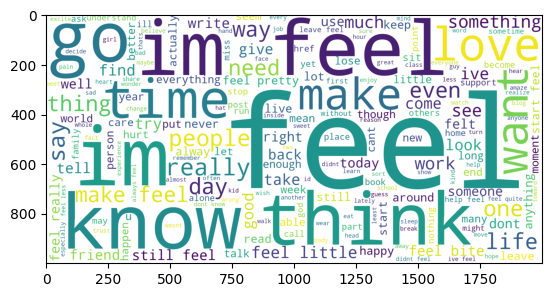

In [200]:
word = WordCloud(width = 2000, height = 1000, background_color = 'white').generate(" ".join(word_cloud))
plt.imshow(word)
plt.show()

In [201]:
vector = CountVectorizer(ngram_range = (1,2))
vector_matrix = vector.fit_transform(data)
x = vector_matrix
y = df.label

#### Test Data

In [202]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size = 0.8, random_state = 2)

In [203]:
xtrain.shape, ytrain.shape

((14400, 111431), (14400,))

In [204]:
rfmodel = RandomForestClassifier()
rfmodel.fit(xtrain,ytrain)

RandomForestClassifier()

In [205]:
def final_result(prediction):
    if prediction == 0:
        print('Negative Statement')
    elif prediction == 1:
        print('Postitive Statement')
    else:
        print('Invalid Statement')

In [216]:
def sentiment_prediction(input):
    converted_input = conversion(input)
    vectorized_input = vector.transform(converted_input)
    prediction = rfmodel.predict(vectorized_input)
    final_result(prediction)

### Performance

In [207]:
def model_prediction(name, model):
        ypred = model.predict(xtest)
        precision, recall, f_beta, support = precision_recall_fscore_support(ytest, ypred, beta=2, pos_label=1, average='weighted', zero_division=1)
        auc = roc_auc_score(ytest, ypred)
        accuracy = accuracy_score(ytest, ypred)
        print(f"Model name : {name}")
        print(f"Accuracy is: {accuracy:.2f}")
        print(f"Precision is: {precision:.2f}")
        print(f"Recall is: {recall:.2f}")
        print(f"Fscore is: {f_beta:.2f}")
        print(f"AUC is: {auc:.2f}\n")

In [208]:
rfmodel.score(xtest, ytest)

0.9472222222222222

In [209]:
model_prediction('Random Forest',rfmodel)

Model name : Random Forest
Accuracy is: 0.95
Precision is: 0.95
Recall is: 0.95
Fscore is: 0.95
AUC is: 0.95



### Prediction

In [210]:
input1 = ["Sometimes I just want to punch someone in the face."]
input2 = ["I bought a new phone and it's so good."]

In [219]:
sentiment_prediction(["He was speechles when he found out he was accepted to this new job"])
sentiment_prediction(["This is outrageous, how can you talk like that?"])
sentiment_prediction(["I feel like im all alone in this world"])
sentiment_prediction(["He is really sweet and caring"])
sentiment_prediction(["Hearty Congratulations to the Entire team of #RRR . What a spectacular movie. My respect to our pride @ssrajamouli garu for the vision. Soo proud of my brother a mega power @AlwaysRamCharan for a killer & careers best performance. My Respect & love to my bava… power house"])

Postitive Statement
Negative Statement
Negative Statement
Postitive Statement
Postitive Statement


In [218]:
import pickle
pickle.dump(rfmodel, open('sentiment.pkl','wb'))